In [1]:
import numpy
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '/home/alg010/repos/coda/codes/')
import CodaPCA
sys.path.insert(1, '/home/alg010/repos/RM-tools/')
from RMutils import util_RM

import cmocean
import sklearn.svm

import tensorflow
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1682498100411193606
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 987046448947926702
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 1765456318329794679
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7733775565
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11524972075812916880
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:
import importlib
import generate_spectra
importlib.reload(generate_spectra)
importlib.reload(sklearn.svm)

<module 'sklearn.svm' from '/home/alg010/miniconda3/lib/python3.6/site-packages/sklearn/svm/__init__.py'>

In [23]:
# freqs = numpy.loadtxt('freqs_cosmology_22.txt')
# Matches Brown+18.
band12 = numpy.linspace(700, 1300, 600) * 1e6  # Hz
band3 = numpy.linspace(1500, 1800, 300) * 1e6  # Hz
freqs = numpy.concatenate((band12, band3))

In [ ]:
spectra = generate_spectra.generate_spectra(
    freqs, util_RM, n_spectra=100000, phi_sampling=500, max_noise=0.333,
    min_phi=-100, max_phi=100, phi_padding=50)

100%|██████████| 100000/100000 [00:14<00:00, 6999.66it/s]


In [ ]:
# plt.plot()
%matplotlib inline
plt.plot(abs(spectra['sim_fdf'][2]))
plt.plot(abs(spectra['targets'][2]))

In [ ]:
pca = CodaPCA.CodaPCA(3, 0.01, [20, 20], alg=CodaPCA.Alg.CODAAE)

In [ ]:
features = abs(spectra['sim_fdf'])
features.shape

In [ ]:
tf = pca.fit_transform(features, epochs=100)

In [ ]:
tf

In [ ]:
%matplotlib inline
plt.scatter(tf[~spectra['simple'], 0], tf[~spectra['simple'], 1])
plt.scatter(tf[spectra['simple'], 0], tf[spectra['simple'], 1])
# plt.legend(['complex', 'simple'])
# plt.subplot(1, 2, 2)
# plt.scatter(tf[~spectra['simple'], 2], tf[~spectra['simple'], 1], s=10)
# plt.scatter(tf[spectra['simple'], 2], tf[spectra['simple'], 1], s=10)
# plt.legend(['complex', 'simple'])
plt.show()

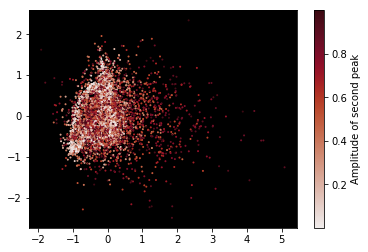

In [126]:
%matplotlib inline
ax = plt.subplot(1, 1, 1, facecolor='black')
plt.scatter(tf[~spectra['simple'], 0],
            tf[~spectra['simple'], 1],
            c=spectra['amps'][~spectra['simple'], 1],
            cmap=cmocean.cm.amp, s=1)
cb = plt.colorbar()
cb.set_label('Amplitude of second peak')

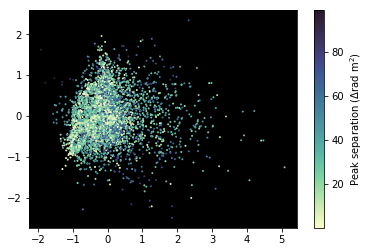

In [127]:
ax = plt.subplot(1, 1, 1, facecolor='black')
separations = abs(spectra['depths'][:, 0] - spectra['depths'][:, 1])
plt.scatter(tf[~spectra['simple'], 0],
            tf[~spectra['simple'], 1],
            c=separations[~spectra['simple']],
            cmap=cmocean.cm.deep, s=1)
cb = plt.colorbar()
cb.set_label('Peak separation ($\\Delta$rad m$^2$)')

In [143]:
# svm = sklearn.svm.OneClassSVM(kernel='rbf', gamma=3)
svm = sklearn.svm.SVC(probability=True, gamma=3)
svm.fit(tf, spectra['simple'])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=3, kernel='rbf', max_iter=-1,
    probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [144]:
# X, Y = numpy.mgrid[-2.5:15.0:0.5, -4:10:0.5]
# XY = numpy.stack([X.ravel(), Y.ravel()]).T
# scores = svm.score_samples(XY)

In [145]:
# plt.pcolormesh(X, Y, scores.reshape(X.shape))
# # plt.scatter(tf[~spectra['simple'], 0], tf[~spectra['simple'], 1], s=10)
# # plt.scatter(tf[spectra['simple'], 0], tf[spectra['simple'], 1], s=10, color='black')
# # plt.legend(['complex', 'simple'])

In [149]:
predictions = svm.predict_proba(tf)[:, 1]

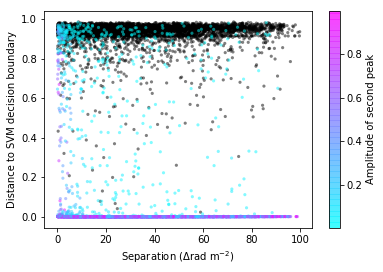

In [150]:
%matplotlib inline
separations = abs(spectra['depths'][:, 0] - spectra['depths'][:, 1])
amps = spectra['amps'][:, 1]
plt.scatter(separations[spectra['simple']], predictions[spectra['simple']],
            s=10, alpha=0.5, edgecolor='None',
            c='black')
plt.scatter(separations[~spectra['simple']], predictions[~spectra['simple']],
            s=10, alpha=0.5, edgecolor='None',
            c=amps[~spectra['simple']],
            cmap='cool')
plt.xlabel('Separation ($\\Delta$rad m$^{-2}$)')
plt.ylabel('Distance to SVM decision boundary')
cb = plt.colorbar()
cb.set_label('Amplitude of second peak')

In [155]:
import sklearn.metrics, scipy.special
cm = sklearn.metrics.confusion_matrix(spectra['simple'], svm.predict(tf)).astype(float)
cm /= cm.sum(axis=1, keepdims=True)
print(cm)

cm_brown = numpy.array([[46538, 3618],
                        [1481, 48318]]).astype(float)
cm_brown /= cm_brown.sum(axis=1, keepdims=True)
print(cm_brown)
# p, r, c = sklearn.metrics.precision_recall_curve(spectra['simple'], scipy.special.expit(predictions))
# plt.plot(p, r)
# plt.xlabel('Precision')
# plt.ylabel('Recall')

[[0.88724995 0.11275005]
 [0.         1.        ]]
[[0.92786506 0.07213494]
 [0.02973955 0.97026045]]


In [ ]:
real_spectra = numpy.load('/home/alger/possum/alger/COSMOLOGY_22/all_spectra.npy')

In [ ]:
real_labels = numpy.load('/home/alger/possum/alger/COSMOLOGY_22/pixel_labels.npy')

In [ ]:
real_spectra_mag = abs(real_spectra)
real_spectra_mag_ = real_spectra_mag / real_spectra_mag.max(axis=1, keepdims=True)
real_spectra_mag_.dtype

In [ ]:
tf_real_simtrained = pca.transform(real_spectra_mag_)

In [ ]:
spectra.keys()

In [ ]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tf[spectra['simple'], 0][::10], tf[spectra['simple'], 1][::10], tf[spectra['simple'], 2][::10], s=10)

for i in range(100):
    mask = real_labels == i
    avg = tf_real_simtrained[mask].mean(axis=0)
    plt.scatter(avg[0], avg[1], s=10, c='k', marker='x')

In [ ]:
pca_real = CodaPCA.CodaPCA(2, 1e-3, [10, 10], alg=CodaPCA.Alg.CODAAE)

In [ ]:
tf_real = pca_real.fit_transform(real_spectra_mag, epochs=100)

In [ ]:
plt.hexbin(tf_real[:, 0], tf_real[:, 1], bins='log')

In [ ]:
tf_sim_realtrained = pca_real.transform(features)

In [ ]:
plt.scatter(tf_sim_realtrained[~spectra['simple'], 0], tf_sim_realtrained[~spectra['simple'], 1], s=10)
plt.scatter(tf_sim_realtrained[spectra['simple'], 0], tf_sim_realtrained[spectra['simple'], 1], s=10)
plt.legend(['complex', 'simple'])